# Projet Python - TOP14 Rugby

par Benjamin Cerf, Tristan Delhaye & Mathieu Roig

<a id="intro"></a>
# Introduction

Les rencontres sportives sont un domaine propice à l'utilisation de statistiques, ne serait ce que pour l'industrie des paris sportifs générant plusieurs milliards d'euros de chiffre d'affaire à l'échelle de la France en 2024. Avec l'occasion de la coupe du monde de rugby en France en 2023, le staff de l'équipe de France avait mis en avant l'utilisation de plus en plus d'analyse de données pour prendre leurs décisions, dans un sport qui tend à se professionnaliser mais qui est resté historiquement loin de ces considérations, contrairement au football ou au basketball.

Notre questionnement a alors été de savoir si à partir de données consultables en libre accès, il nous serait possible de prédire l'issue d'une rencontre, et donc aussi de prédire le classement final d'une saison afin de savoir où se situerait le club que l'on supporte, le Stade Toulousain. La première source d'ennui a été d'abord de trouver ces données, qui sont malheureusement détenues par des cabinets de conseils privés comme [OptaAnalyst](https://theanalyst.com/) qui les vendent aux équipes et qui ne sont donc pas disponibles en libre accès. Les données qui nous ont paru les plus exploitables sont celles du championnat français de 1ère division regroupant les 14 meilleurs clubs français, surnommé le TOP14.

Ce projet vise à combler cette lacune en rendant accessibles les données du TOP14, tout en offrant la possibilité d'explorer et de modéliser les performances des équipes. L'objectif est d'apporter une meilleure compréhension des facteurs influençant les résultats du championnat, en explorant les données de manière approfondie et en créant un modèle prédisant le classement final. Face à la difficulté d'obtenir des données détaillées à travers des sites spécialisés nous optons pour une approche de web-scraping sur Wikipédia. Notre démarche a été de rendre ces données accessibles et reproductibles, avec l'ambition de prédire le classement et les résultats de la saison en cours. Notre projet repose sur plusieurs scripts appelés dans ce fichier, permettant de garantir la reproductibilité des analyses et de faciliter leur utilisation future.

Notre projet est structuré de manière à guider l'utilisateur à travers les différentes étapes de l'analyse, de la collecte des données à nos résultats. La section [Données](#données) détaille le processus de [Web-Scraping](#scraping), ainsi que les étapes de [Nettoyage](#nettoyage) et de [Regroupement](#regroupement) des données. Nous nous concentrons ensuite sur la [Visualisation](#visual) des données et leur [Analyse](#analyse), avant de détailler notre [Modèle prédictif](#predict) et de conclure.

<a id="sommaire"></a>
### Sommaire
- [Introduction](#intro)
  - [Sommaire](#sommaire)
  - [Installation](#installation)
- [Données](#données)
  - [Web-Scraping](#scraping)
  - [Nettoyage](#nettoyage)
  - [Regroupement](#regroupement)
  - [Mapping des noms de clubs](#mapping)
- [Statistiques Descriptives](#stats)
  - [Visualisation](#visual)
  - [Analyse](#analyse)
- [Modèle prédictif](#predict)
  - [Prédiction du classement](#classement)
  - [Prédiction des résultats](#results)
- [Conclusion](#conclu)

<a id="installation"></a>
### Installation

In [41]:
#packages:
from io import StringIO
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import sys
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#lxml
subprocess.check_call([sys.executable, "-m", "pip", "install", "lxml"])

# pour partie predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

<a id="données"></a>
# Données

<a id="scraping"></a>
### Web-Scraping

Nous récupérons sur Wikipédia les données sur le championnat de France de rugby à XV de 2016 à aujourd'hui. Chaque saison a sa propre page wikipédia dédiée et la présentation des résultats peut légèrement différer en fonction de l'année: voir ici la saison [2016-2017](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017) par rapport à la saison [2024-2025](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025).

In [42]:
urls = [f"https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_{year}-{year+1}"
    for year in range(2016, 2025)]
print(urls)

['https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2017-2018', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2018-2019', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2019-2020', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2020-2021', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2021-2022', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2022-2023', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2023-2024', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025']


Nous utilisons donc plusieurs versions d'une même fonction data dans scrapData.py qui récupère les tableaux de présentation générale, du classement, de son évolution, les résultats détaillés par match, et aussi la forme des équipes en fonction des jours de match.

In [43]:
sys.path.append(os.path.abspath('./scripts'))
from scrapData import data2325, data2223, data2122, data2021, data1920, data1619

tab1617 = data1619(urls[0])
tab1718 = data1619(urls[1])
tab1819 = data1619(urls[2])
tab1920 = data1920(urls[3])
tab2021 = data2021(urls[4])
tab2122 = data2122(urls[5])
tab2223 = data2223(urls[6])
tab2324 = data2325(urls[7])
tab2425 = data2325(urls[8])

<a id="nettoyage"></a>
### Nettoyage

La fonction nettoyage de cleanData.py uniformise les données du scraping. Les noms des équipes sont nettoyés, on se débarrasse des notes, et les classements sont tous mis sous forme numérique (ex: 1er -> 1, 2ème -> 2...). Les valeurs manquantes sont aussi remplacées par un tiret.

In [44]:
from cleanData import nettoyage

nettoyage(*tab1617)
nettoyage(*tab1718)
nettoyage(*tab1819)
nettoyage(*tab1920)
nettoyage(*tab2021)
nettoyage(*tab2122)
nettoyage(*tab2223)
nettoyage(*tab2324)
nettoyage(*tab2425)

<a id="regroupement"></a>
### Regroupement

Chaque tab est en réalité une liste de 5 dataframes. Nous allons donc pour chaque tableau fusionner les résultats des 9 dernières années, sauf celui des résultats globaux. 

In [45]:
# On va maintenant fusionner les tableaux, on change le nom pour faciliter la boucle :
tab1 = tab1617
tab2 = tab1718
tab3 = tab1819
tab4 = tab1920
tab5 = tab2021
tab6 = tab2122
tab7 = tab2223
tab8 = tab2324
tab9 = tab2425

# On crée une fonction qui permet d'ajouter une colonne année à chaque tableau pour bien pouvoir les séparer par année si besoin après
def ajout_an(df,i):
   df["année"] = 2016 + i
   return df

# On va faire maintenant une boucle pour concaténer les tableaux entre eux :
tableauglobal = [pd.DataFrame() for _ in range(5)]
# On remarquera que l'on ne prend pas le tableau résultat global car les équipes du championnat changent chaque année donc ce n'est pas possible de le concaténer

for j in range(1, 10):
    for i in range(5):
        if i == 2:
            pass  # on ne récupère pas le tableau résultat
        else:
         tableauglobal[i] = pd.concat([tableauglobal[i], ajout_an(eval(f"tab{j}")[i], j - 1)], ignore_index=True)

tab_presentation_global = tableauglobal[0]
tab_classement_global = tableauglobal[1]
tab_evolution_classement_global = tableauglobal[3]
tab_forme_global = tableauglobal[4]
# On convertit aussi ceraines données au format numérique
tab_presentation_global['Budget en M€'] = pd.to_numeric(tab_presentation_global['Budget en M€'], errors='coerce')
tab_presentation_global['Classement précédent'] = pd.to_numeric(tab_presentation_global['Classement précédent'], errors='coerce')


<a id="mapping"></a>
### Mapping des noms de clubs

Enfin certaines équipes n'ont pas toujours leur nom écrit de la même façon. On se rend compte qu'un même club est appelé de manière différente selon le dataframe, par exemple 'Stade français' ou 'Stade français Paris'. On recherche alors tableau par tableau les clés uniques en les comparant au tableau de classement général pour obtenir le mapping suivant. On répertorie alors les appellations différentes pour ensuite pourvoir les harmoniser.

In [46]:
presentation = tab_presentation_global
classement = tab_classement_global
evolution = tab_evolution_classement_global
forme = tab_forme_global

# On commence déjà par uniformiser le nom de la colonne 'Club':
evolution.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)
forme.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)

mapping = {
    'Paris' : 'Stade français Paris',
    'Stade français': 'Stade français Paris',
    'Clermont': 'ASM Clermont',
    'La Rochelle': 'Stade rochelais',
    'Toulouse': 'Stade toulousain',
    'Bayonne': 'Aviron bayonnais',
    'Brive': 'CA Brive',
    'Montpellier': 'Montpellier HR',
    'Toulon': 'RC Toulon',
    'Castres': 'Castres olympique',
    'Pau': 'Section paloise',
    'Agen': 'SU Agen',
    'Grenoble': 'FC Grenoble',
    'Oyonnax': 'US Oyonnax',
    'Perpignan': 'USA Perpignan',
    'Bordeaux-Bègles': 'Union Bordeaux Bègles',
    'Bordeaux Bègles' : 'Union Bordeaux Bègles',
    'Lyon' : 'Lyon OU'
}

# On a plus qu'à uniformiser les noms dans tout les tableaux
presentation['Club'] = presentation['Club'].replace(mapping)
classement['Club'] = classement['Club'].replace(mapping)
forme['Club'] = forme['Club'].replace(mapping)
evolution['Club'] = evolution['Club'].replace(mapping)

#print(presentation.describe())
#print(classement.describe())
#print(forme.describe())
#print(evolution.describe())

On agrège ensuite les différents tableaux en un seul dataframe nommé données, pour les stocker dans le dossier data. Si nos données étaient plus volumineuses, il serait aussi possible de les stocker sur le S3 du SSPcloud.

In [47]:
data = pd.merge(presentation, classement, on=['Club', 'année'], how='inner')
data = pd.merge(data, evolution, on=['Club', 'année'], how='inner')
data = pd.merge(data, forme, on=['Club', 'année'], how='inner')

data.to_csv('./data/données.csv', index=False)

# pour fixer les données nettoyées dans SSPcloud ?
#import s3fs
#MY_BUCKET =

<a id="stats"></a>
# Statistiques Descriptives

<a id="visual"></a>
### Visualisation

La fonction club de computeData permet d'obtenir les statistiques descriptives pour un club en particulier, pour chaque année qu'il passe dans le top 14: son budget en M€, son entraîneur, son rang, et le nombre de recontres jouées, dont les victoires et les défaites.

Par exemple pour Toulouse, club le plus titré avec 23 victoires en championnat de France, ou encore pour l'USA Perpignan, qui est monté plus récemment en TOP14:



In [48]:
from computeData import club

toulouse=club("Stade toulousain", tab_presentation_global, tab_classement_global)
print(toulouse)

perpignan=club("USA Perpignan", tab_presentation_global, tab_classement_global)
print(perpignan)


                       24/25     23/24     22/23     21/22     20/21  \
Budget en M€            49.0      46.3       NaN      37.3      36.6   
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola   
Rang                       2         1         1         4         1   
J                         12        26        26        26        26   
V                          8        16        17        15        17   
D                          3         9         8        11         8   
Diff                     159       173       208       206       210   

                       19/20     18/19     17/18     16/17  
Budget en M€            37.2      32.0     30.86      31.5  
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  
Rang                       7         1         3        12  
J                         17        26        26        26  
V                          8        21        16        11  
D                          8         3         9        1

On peut visualiser l'évolution du budget des clubs au sein du championnat. La page Wikipédia de la saison 2022 ne renseigne d'ailleurs pas les budgets des clubs. Le budget moyen du TOP14 passe de 24M€ à 30M€, une augmentation de 25% à comparer avec une inflation de l'euro de 17% entre 2016 et 2024. 
On peut aussi remarquer deux outliers: le SU Agen en 2017 avec un faible budget de 12M€, et aussi le Stade Toulousain en 2024 avec un budget record de 49M€.

/tmp/ipykernel_392367/2461186081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")


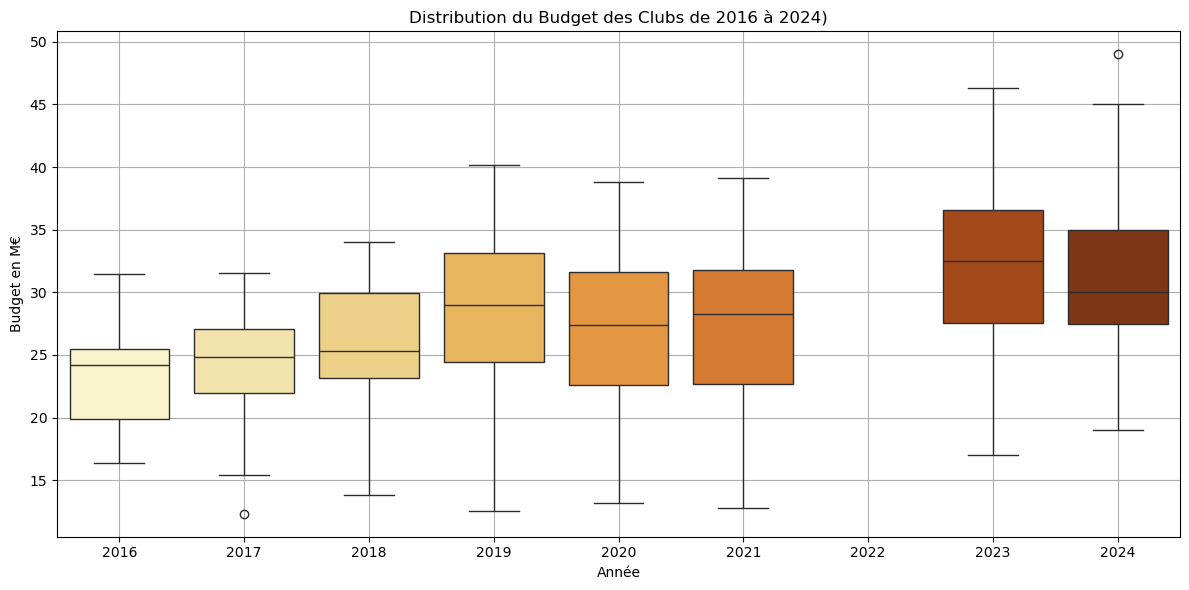

                      Club  Budget en M€
112       Stade toulousain          49.0
113   Stade français Paris          45.0
114  Union Bordeaux Bègles          30.0
115              RC Toulon          35.0
116        Stade rochelais          37.0
117              Racing 92          27.3
118      Castres olympique          25.0
119           ASM Clermont          34.0
120        Section paloise          28.0
121          USA Perpignan          22.5
122                Lyon OU          35.0
123       Aviron bayonnais          30.0
124         Montpellier HR          28.0
125              RC Vannes          19.0


In [49]:
data_filtered = data[data["année"].isin(range(2016, 2025))]
plt.figure(figsize=(12, 6))
sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")

plt.title("Distribution du Budget des Clubs de 2016 à 2024)")
plt.xlabel("Année")
plt.ylabel("Budget en M€")

plt.grid(True)
plt.tight_layout()
plt.show()

data_2024 = data[data["année"] == 2024]
print(data_2024[["Club", "Budget en M€"]])

Le Stade Toulousain va-t-il encore gagner cette année ? Examinons tout d'abord la concurrence: on peut représenter l'évolution du TOP14 en entier.

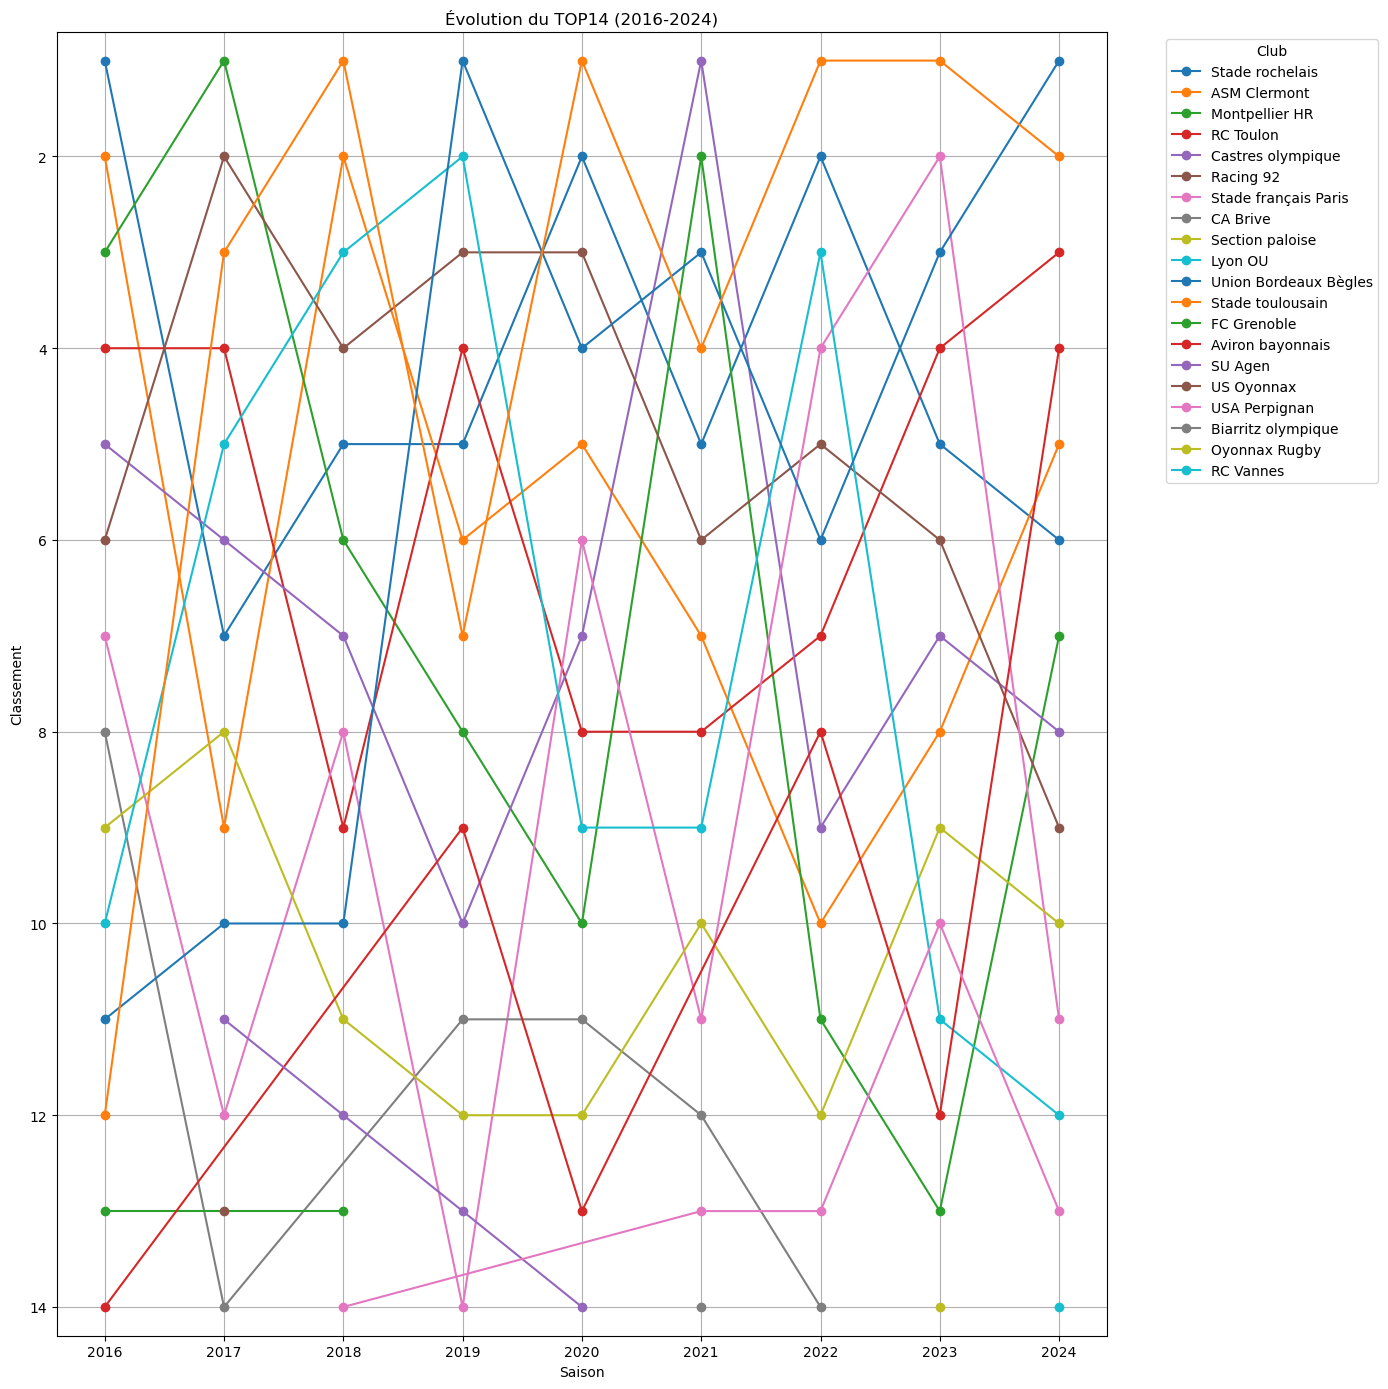

In [50]:
#filtrer pour le top
top_10_per_year = (
    data.sort_values(by=["année", "Rang"])
    .groupby("année")
    .head(14)
    .sort_values(by=["année", "Rang"])
)

plt.figure(figsize=(14, 14))
for club in top_10_per_year["Club"].unique():
    club_data = top_10_per_year[top_10_per_year["Club"] == club]
    plt.plot(club_data["année"], club_data["Rang"], marker="o", label=club)

plt.gca().invert_yaxis()  # le 1 en haut !
plt.ylim(14.3, 0.7) # pour choisir le top?

plt.title("Évolution du TOP14 (2016-2024)")
plt.xlabel("Saison")
plt.ylabel("Classement")
plt.legend(title="Club", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

Cependant le graphique ci-dessus n'est pas très lisible. Partant du principe qu'on ne change pas une équipe qui gagne, gardons uniquement les équipes ayant gagné le championnat depuis 2016 pour observer l'évolution du top7. Il semble que les deux favoris pour cette saison soient L'Union Bordeaux-Bègles et le Stade Toulousain, qui comme nous l'avons vu est historiquement le plus titré et a aussi le plus gros budget de la saison.

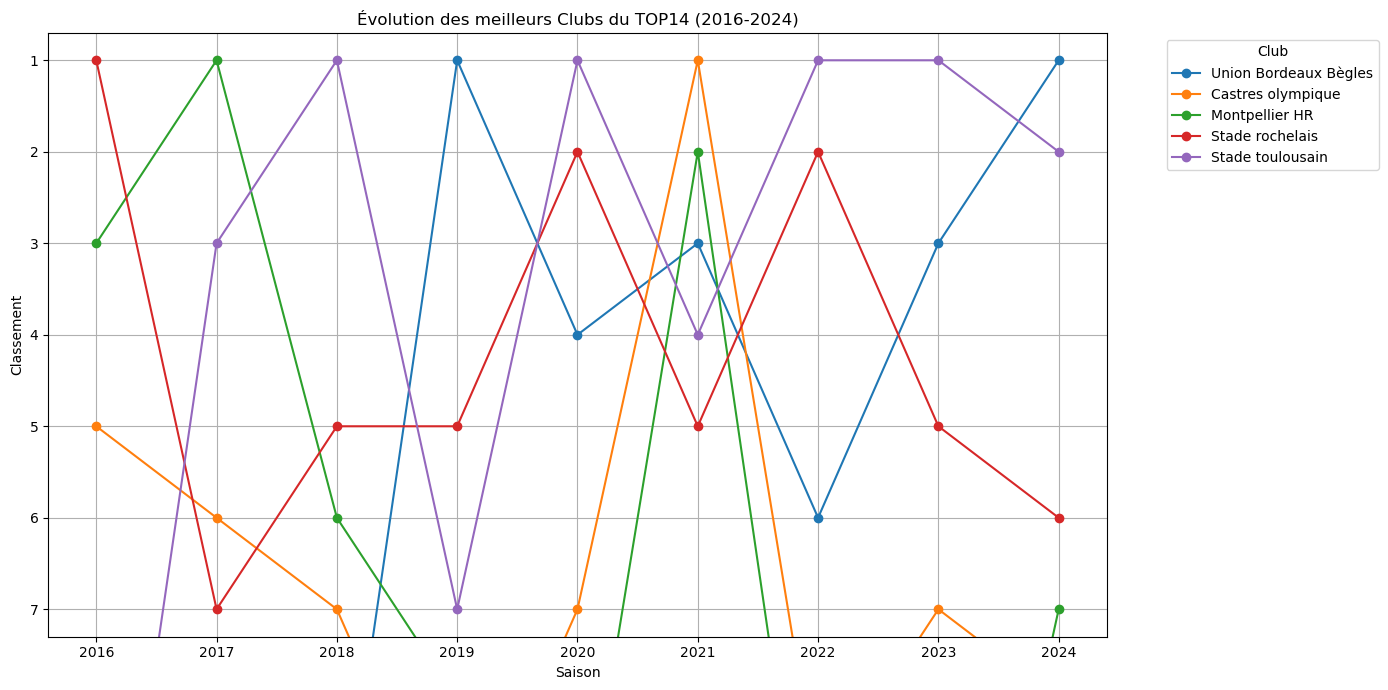

In [51]:
top_1_clubs = data[data["Rang"] <= 1]["Club"].unique()
filtered_data = data[data["Club"].isin(top_1_clubs)]

# plot
plt.figure(figsize=(14, 7))
for club in filtered_data["Club"].unique():
    club_data = filtered_data[filtered_data["Club"] == club]
    plt.plot(club_data["année"], club_data["Rang"], marker="o", label=club)

plt.gca().invert_yaxis()
plt.ylim(7.3, 0.7)  

plt.title("Évolution des meilleurs Clubs du TOP14 (2016-2024)")
plt.xlabel("Saison")
plt.ylabel("Classement")
plt.legend(title="Club", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


<a id="analyse"></a>
### Analyse

Analysons en détail les performances de ces clubs grâce à la fonction plot_club_evolution de computeData.py: celle-ci représente l'évolution du classement de l'équipe sur les 26 journées de chacune des saisons, ainsi que son score cumulatif.


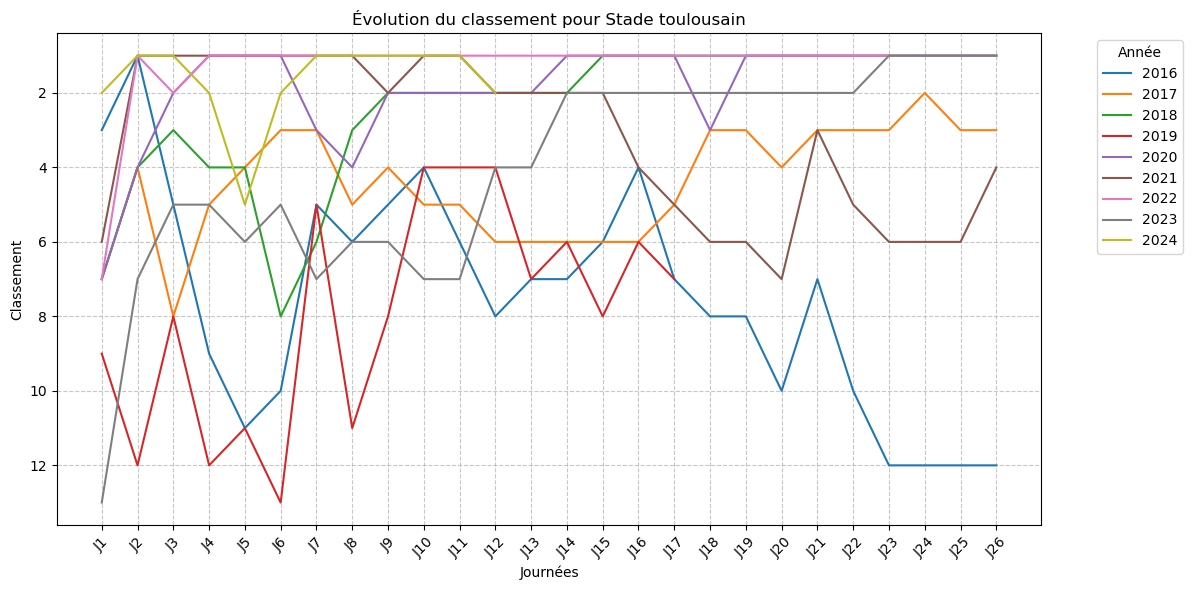

/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in

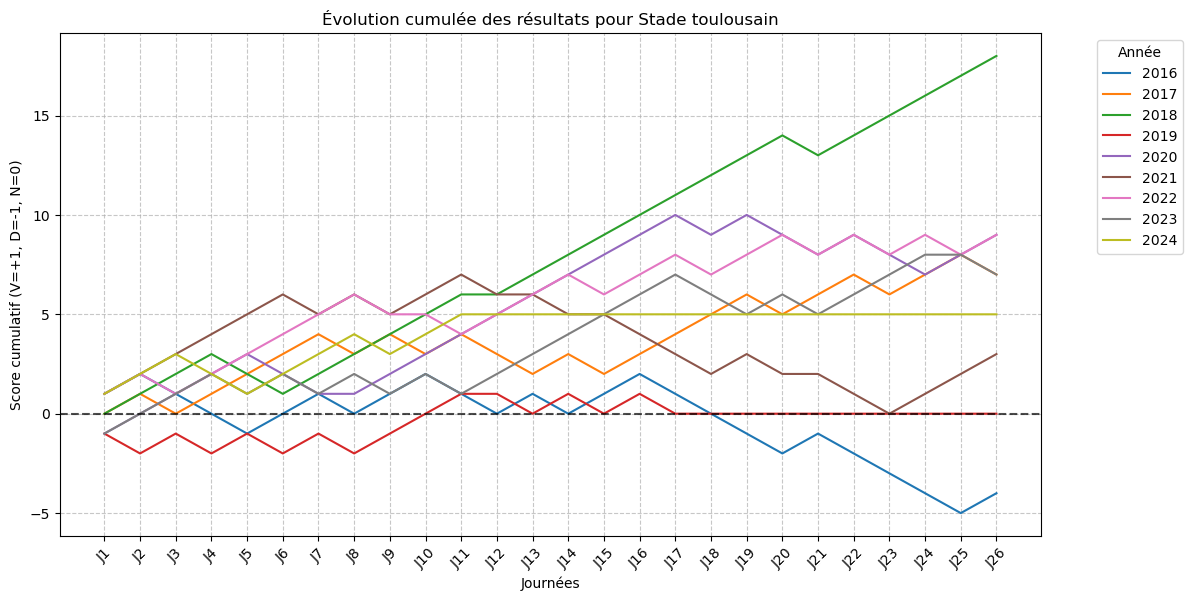

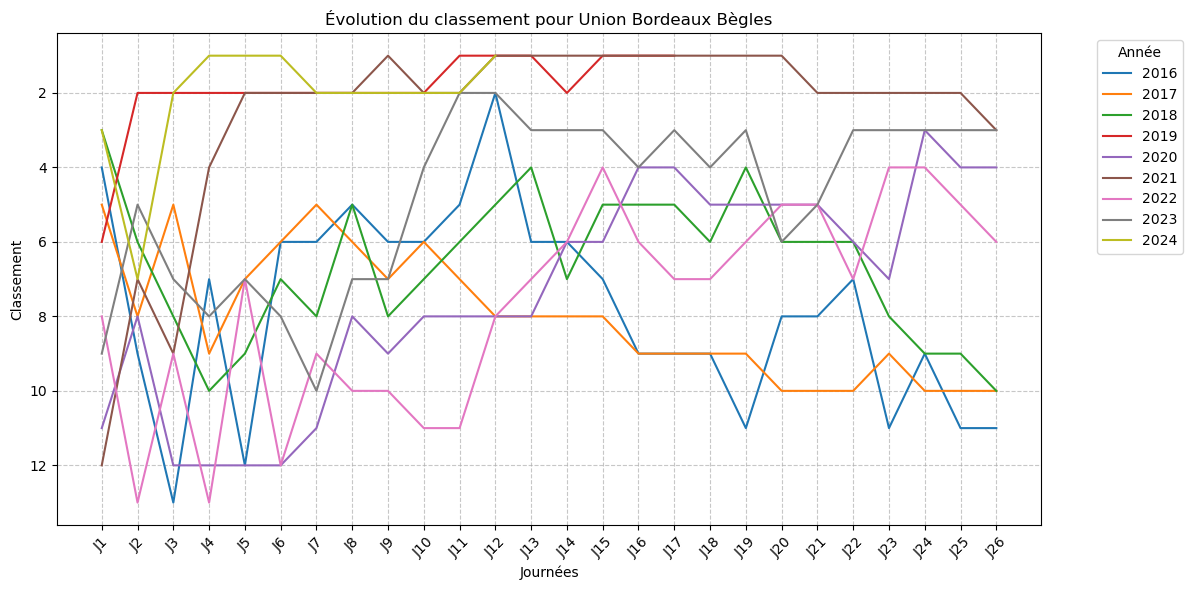

/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in

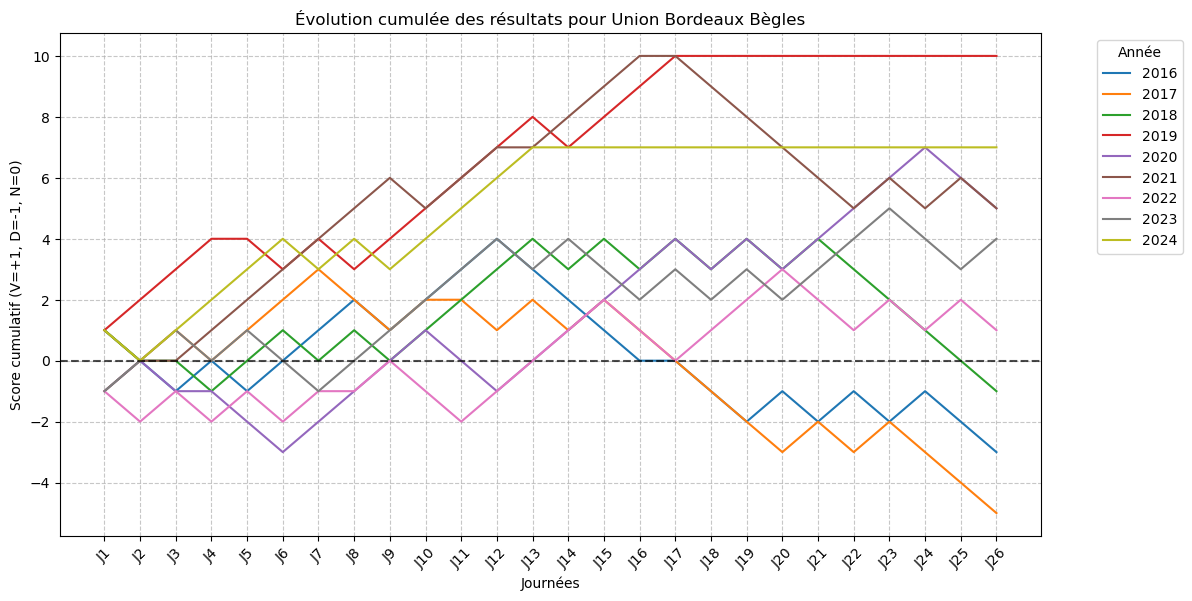

In [52]:
from computeData import plot_club_evolution

plot_club_evolution("Stade toulousain", tab_evolution_classement_global, tab_forme_global)
plot_club_evolution("Union Bordeaux Bègles", tab_evolution_classement_global, tab_forme_global)

<a id="predict"></a>
# Modèle prédictif

Après un aperçu des données à notre disposition, nous allons chercher à prédire le classement du TOP14 de cette saison, mais aussi les résultats des matchs à venir.

<a id="classement"></a>
### Prédiction du classement

Tout d'abord pour prédire le classement, on utilise un modèle Random Forest Regressor. Il faut d'abord préparer les données:


In [53]:
X = data.drop(columns=['Rang','J26_x'])  # On retire la varibale à prédire, J26_x est le classement le jour 26 qui est le même que le classement final
y = data['Rang']  # Classement final On prend la variable que l'on souhaite prédire
# On prend un jeu d'entraînement et de test (pour l'année 2023/2024, on s'entraîne sur le passé)
X_train = X[data['année'] < 2023]
X_test = X[data['année'] >= 2023]
y_train = y[data['année'] < 2023]
y_test = y[data['année'] >= 2023]
# On sépare les variables numériques et catégorielles
variables_numériques = X_train.select_dtypes(include=['int64', 'float64']).columns
variables_catégorielles = X_train.select_dtypes(include=['object']).columns
# ¨Pipeline permet de faire plusieurs modifications sur les données en une seule fois :
# Pour les variables numériques
var_num_ajustées = Pipeline(steps=[
    ('valeur_manquantes', SimpleImputer(strategy='mean')),  # On remplace les valeurs manquantes par la moyenne de la variable
    ('standardiser', StandardScaler())  # On standardise les variables
])
# Pour les variables catégorielles
var_cat_ajustées = Pipeline(steps=[
    ('valeur_manquantes', SimpleImputer(strategy='most_frequent')),  # Lorsqu'il manque des données on les remplace par la catégorie la plus fréquente
    ('transfomration_binaire', OneHotEncoder(handle_unknown='ignore'))  # Transformation en variables binaires
])
# Combiner les variables ajustées grâce à columnTransformer qui permet d'effectuer des modifications différentes sur des variables d'un même datatset
# Ici on sépare catégorielle et numérique et on applique les 2 transformations qu'on a définie précédement
var_combinée = ColumnTransformer(
    transformers=[
        ('num', var_num_ajustées, variables_numériques),
        ('cat', var_cat_ajustées, variables_catégorielles)
    ])

On entraîne d'abord le modèle à prédire la saison 2023-2024, et on observe son erreur moyenne absolue (MAE), et son erreur quadratique moyenne (RMSE).

In [54]:
# Modélisation avec RandomForestRegressor
# Pipeline complet avec préprocesseur et modèle Random Forest
modele = Pipeline(steps=[
    ('données_utilisées', var_combinée),
    ('forêt_aléatoire', RandomForestRegressor(n_estimators=100, random_state=2024))  # On fixe la seed à 2024 pour retrouver nos résultats
])
# Entraîner le modèle
modele.fit(X_train, y_train)

y_pred = modele.predict(X_test) # on fait nos prédictions avec le modèle

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.3135714285714284
Root Mean Squared Error: 1.7078662543820995


Voici à présent les prédictions du modèle pour le classement des équipes du TOP14, pour les saisons 2023-2024 et 2024-2025. La prédiction de 2023-2024 est bien conforme au classement réel (voir le graphique du TOP14 dans la partie [Visualisation](#visual)).
Et selon le modèle, cette année le Stade Toulousain arrivera en 2ème place derrière l'Union Bordeaux-Bègles.

In [55]:
future_data23 = X[X['année'] == 2023].reset_index(drop=True)# on sélectionne les données pour 2022/2023 
 # et on initialise l'indexation à 0 pour pouvoir fusionner par la suite
predictions23 = pd.Series(modele.predict(future_data23), name='Rang_prédit') # On transforme le array en Series et on rajoute le nom Rang_prédit à la colonne
pred23 = pd.concat([future_data23['Club'], predictions23], axis=1) # On concatène les 2 tableaux
pred23['Rang_prédit_ajusté'] = pred23['Rang_prédit'].rank(method='min') # On crée un rang ajusté (détail de l'idée un peu plus bas)
print("Predictions pour 2023/2024:", pred23) # On affiche la prédiction

# On fait de même pour 2024 : 
future_data24 = X[X['année'] == 2024].reset_index(drop=True) 
predictions24 = pd.Series(modele.predict(future_data24), name='Rang_prédit')
pred24 = pd.concat([future_data24['Club'], predictions24], axis=1)
pred24['Rang_prédit_ajusté'] = pred24['Rang_prédit'].rank(method='min')
print("Predictions pour 2024/2025:", pred24)

Predictions pour 2023/2024:                      Club  Rang_prédit  Rang_prédit_ajusté
0        Stade toulousain         2.44                 1.0
1         Stade rochelais         6.63                 6.0
2                 Lyon OU        11.07                12.0
3    Stade français Paris         3.23                 2.0
4               Racing 92         6.08                 5.0
5   Union Bordeaux Bègles         4.05                 3.0
6               RC Toulon         4.43                 4.0
7        Aviron bayonnais        10.85                11.0
8       Castres olympique         7.48                 7.0
9            ASM Clermont         8.29                 9.0
10         Montpellier HR        12.64                13.0
11        Section paloise         7.85                 8.0
12          USA Perpignan         9.75                10.0
13          Oyonnax Rugby        13.02                14.0
Predictions pour 2024/2025:                      Club  Rang_prédit  Rang_prédit_ajusté


Comparons maintenant avec une prédiction ajustée en fonction du rang des autres: on calcule le rang prédit pour chacune des équipes et ensuite on les compare pour donner un rang ajusté, c'est-à-dire l'équipe avec le plus petit rang prédit obtient le rang 1, le deuxième plus petit rang prédit, le rang 2, et ainsi de suite...
Avec le rang ajusté les prédictions sont encore meilleures car les 2 types d'erreurs diminuent.

In [56]:
a=[pred23['Rang_prédit_ajusté'], pred24['Rang_prédit_ajusté']]
a = np.array(a)
a = a.flatten()
print("Mean Absolute Error:", mean_absolute_error(y_test, a))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, a)))

Mean Absolute Error: 0.7142857142857143
Root Mean Squared Error: 1.0


Voyons maintenant comment évolue la prédiction lorsque l'on retire les jours au fur et à mesure, pour ce faire on va stocker les valeurs prédites et les erreurs dans 6 tableaux. On va faire comme si on avait pas accès aux 26 journées de la saison en enlevant une par une les données du jour 25, puis du jour 24, etc... jusqu'au jour 2 de l'année que l'on veut prédire.

La précision du modèle est de moins en moins bonne ce qui était attendu puisqu'on a de moins en moins de données. Mais au final cela reste quand même bon, ce qui s'explique peut-être par le fait que le nom du club joué est ce qui importe le plus, et que les données obtenues sur les différents jours sont très corrélées au nom du club.

In [57]:
PREDICT23 = [] # Contiendra toutes les prédictions pour l'année 2023
PREDICT24 = [] # Contiendra toutes les prédictions pour l'année 2024
MAE = [] # Contiendra les différentes valeurs de léerreur moyenne en valeur absolue au fur et à mesure que l'on retire les variables
RMSE = [] # Pareil que le précédent mais pour la racine carré de l'eereur quadratique
MAE_ajuste = [] # Ces 2 tableaux porteront sur les erreurs liés au classement réajusté par rapport aux autres 
RMSE_ajuste = []
# On les remplit avec les données qu'on a obtnues précédemment
PREDICT23.append(pred23)
PREDICT24.append(pred24)
MAE.append(mean_absolute_error(y_test, y_pred))
RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
MAE_ajuste.append(mean_absolute_error(y_test, a))
RMSE_ajuste.append(np.sqrt(mean_squared_error(y_test, a)))

# On crée une copie de notre jeu de test pour le garder intact
X_test_bis = X_test

# Suppression des colonnes J25_x, J25_y, ..., J2_x, J2_y
for i in range(25, 1, -1):  # Commence à 25 et descend jusqu'à 2
    X_test_bis[f'J{i}_x'] = np.nan
    X_test_bis[f'J{i}_y'] = np.nan
    future_data23 = X_test_bis[X_test_bis['année'] == 2023].reset_index(drop=True) 
    predictions23 = pd.Series(modele.predict(future_data23), name='Rang_prédit')
    pred23 = pd.concat([future_data23['Club'], predictions23], axis=1)
    pred23['Rang_prédit_ajusté'] = pred23['Rang_prédit'].rank(method='min')

    future_data24 = X_test_bis[X_test_bis['année'] == 2024].reset_index(drop=True) 
    predictions24 = pd.Series(modele.predict(future_data24), name='Rang_prédit')
    pred24 = pd.concat([future_data24['Club'], predictions24], axis=1)
    pred24['Rang_prédit_ajusté'] = pred24['Rang_prédit'].rank(method='min')
    
    y_pred = modele.predict(X_test_bis) # On veut calculer les erreurs sur les 2 année à la fois
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    PREDICT23.append(pred23)
    PREDICT24.append(pred24)
    MAE.append(mae)
    RMSE.append(rmse)

    # On fait pareil, mais cette fois-ci avec le rang ajusté
    a=[pred23['Rang_prédit_ajusté'], pred24['Rang_prédit_ajusté']]
    a = np.array(a)
    a = a.flatten()
    MAE_ajuste.append(mean_absolute_error(y_test, a))
    RMSE_ajuste.append(np.sqrt(mean_squared_error(y_test, a)))

/tmp/ipykernel_392367/2666667000.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_bis[f'J{i}_x'] = np.nan
/tmp/ipykernel_392367/2666667000.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_bis[f'J{i}_y'] = np.nan
/tmp/ipykernel_392367/2666667000.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Comparons maintenant le comportement des erreurs pour les valeurs prédites et les valeurs prédites ajustées. On observe alors trois choses:

+ Les valeurs prédites ajustées sont en moyennes plus précises que les valeurs prédites.

+ Plus on a de jours plus l'erreur portant sur les valeurs prédites est réduite, les 2 types d'erreurs sont décroissantes avec le nombres de jours disponibles

+ En revanche pour les valeurs prédites ajustées ce n'est pas aussi simple elle peuvent augmenter ou diminuer si l'on rajoute des jours en plus, mais globalement les erreurs varient moins que pour les valeurs prédites non ajustées.

Il semble que les données obtenues sur les jours ne changent pas beaucoup en moyenne l'erreur moyenne obtenue entre rang et rang_ajusté. En revanche pour la prédiction non ajusté plus on a de jours plus on est précis en moyenne dans nos prédictions, ce qui est bien attendu.


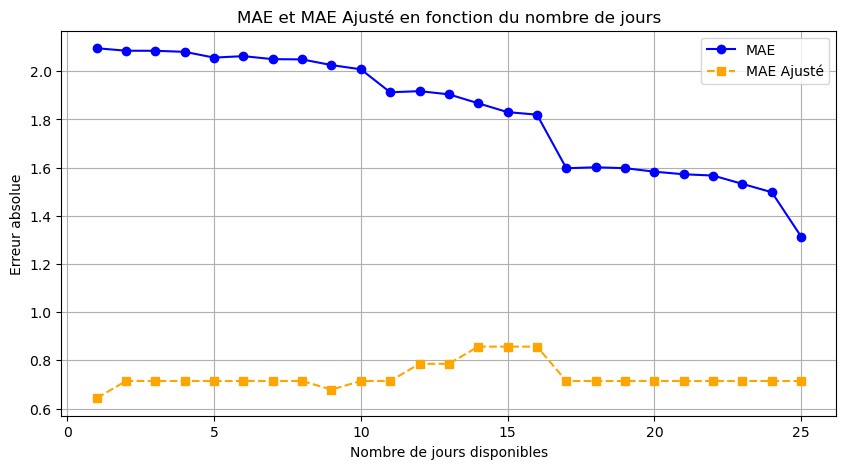

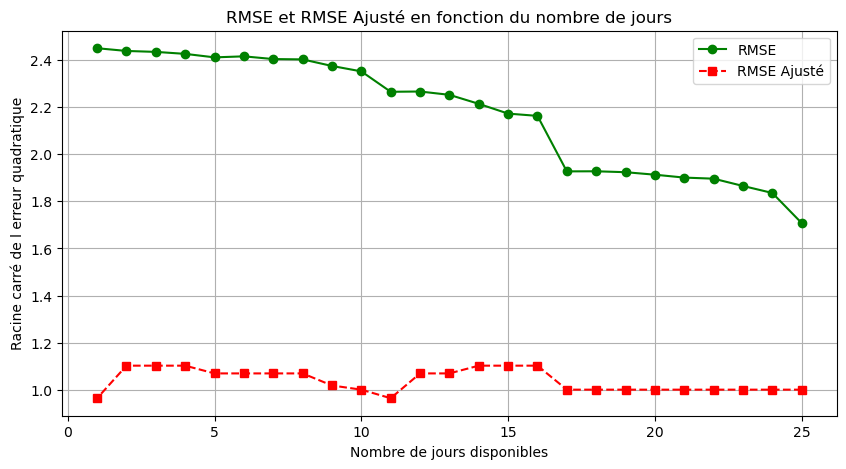

In [58]:
# On crée une variable qui représentera la nombre de jours utilisés pour prédire le classement
y = np.linspace(25, 1, num=25)  

#premier graphe contenant l'erreur e valeur absolue  (MAE et MAE ajusté)
plt.figure(figsize=(10, 5))
plt.plot(y, MAE, label='MAE', marker='o', linestyle='-', color='blue')
plt.plot(y, MAE_ajuste, label='MAE Ajusté', marker='s', linestyle='--', color='orange')
plt.xlabel('Nombre de jours disponibles')
plt.ylabel('Erreur absolue')
plt.title('MAE et MAE Ajusté en fonction du nombre de jours')
plt.legend()
plt.grid(True)
plt.show()

#un deuxième graphe pour la racine carré de l'erreur quadratique (RMSE et RMSE ajusté)
plt.figure(figsize=(10, 5))
plt.plot(y, RMSE, label='RMSE', marker='o', linestyle='-', color='green')
plt.plot(y, RMSE_ajuste, label='RMSE Ajusté', marker='s', linestyle='--', color='red')
plt.xlabel('Nombre de jours disponibles')
plt.ylabel('Racine carré de l erreur quadratique')
plt.title('RMSE et RMSE Ajusté en fonction du nombre de jours')
plt.legend()
plt.grid(True)
plt.show()

Enfin la fonction evol_classement_prédit de predict.py permet de représenter l'évolution du classement prédit d'une équipe en fonction du nombre de jours.

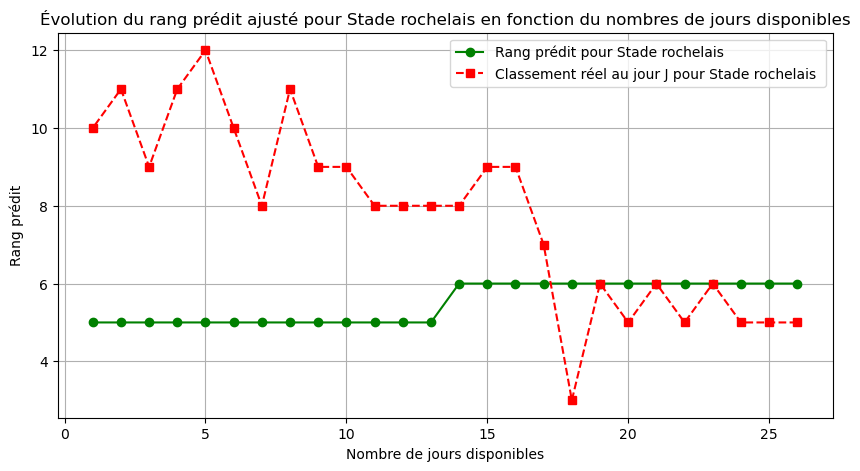

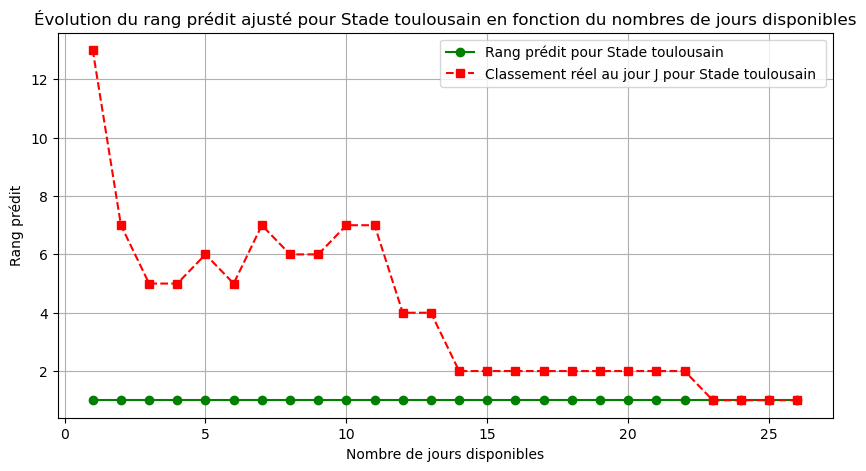

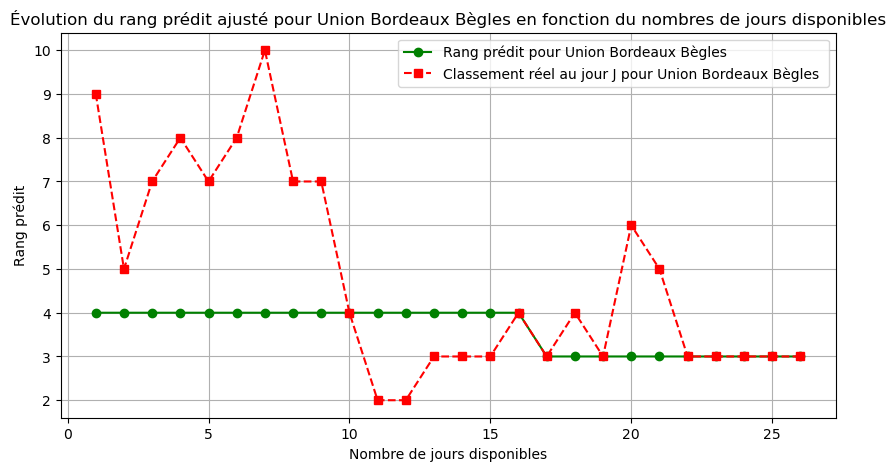

In [59]:
from predict import evol_classement_prédit
evol_classement_prédit('Stade rochelais', 2023) 
evol_classement_prédit('Stade toulousain', 2023) 
evol_classement_prédit('Union Bordeaux Bègles', 2023) 

On remarque que le rang prédit (ajusté) final ne change pas beaucoup selon le nombre de jours que l'on met en entrée (il varie au plus de 1)  
Une chose étrange se passe pour stade rochelais c'est que le rang réel a diminué par rapport au rang des premiers jours mais que le rang prédit lui a augmenté ce qui semble contradictoire.  
En revanche pour Union Bordeaux Bègles le rang prédit diminue en fonction du nombre de jours, ce qui semble logique puisque le rang réel est plus bas sur les derniers jours que sur les premiers.

<a id="results"></a>
### Prédiction des résultats

Faire des prédictions sur les résultats des matchs s'avère légèrement plus compliqué. La fonction resultat_equipe dans predict2.py est en cours de développement et servira à prédire les résultats match par match pour une équipe en particulier, ici pour le Stade Toulousain.

In [ ]:
#from predict2 import uniforme_tab, complete_t9_resultats, resultat_equipe

<a id="conclu"></a>
# Conclusion

En explorant le rugby à XV et le TOP14 sous un prisme de data-scientist, nous avons collecté, nettoyé et structuré les données via web-scraping depuis Wikipédia. Nous avons ensuite construit une base de données solide et aisément reproductible pour des analyses statistiques. Nous avons enfin entraîné un modèle pour prédire le classement final du TOP14 à partir des matchs déjà joués: selon nos prédictions, il semble que l'Union Bordeaux-Bègles s'imposera cette année devant le Stade Toulousain (à vérifier en juin 2025 !):

+ Cependant, nous pouvons être critique sur les données apportées au modèle, on a ici utilisé seulement les informations des statistiques de club sur 9 ans depuis 2016 par manque de données exploitables fournies par Wikipédia, or on se doute que cela représente assez peu de données pour entraîner un modèle. Une saison compte 26 journées, sur 9 ans cela représente donc 234 matchs par équipe en supposant que l'équipe soit présente tous les ans, ce qui est le cas pour le Stade Toulousain mais pas forcément la plupart des autres équipes, par exemple l'USA Perpignan n'est présent que 4 saisons depuis 2016, ce qui réduit de moitié l'échantillon de données pour cette équipe.

+ Notre analyse pourrait aussi être améliorée en intégrant plus de paramètres, comme par exemple des statistiques détaillées sur les joueurs. En effet nous ne prenons pas en compte l'effectif de l'équipe, c'est-à-dire les joueurs qui changent à chaque saison. On peut en général s'attendre à des patterns similaires pour certaines équipes sur 3 ans qui correspondent au projet d'un entraîneur, mais la blessure de certains joueurs en cours de saison ou le fait d'être appelé en sélection internationale n'est pas pris en compte, ce qui est pourtant un facteur décisif.

+ On a alors finalement un modèle qui prédit des résultats cohérents : Vannes est pronostiqué dernier et c'est le club qui vient d'être promu en 1ère division l'an dernier, ce qui est généralement le cas, Bordeaux et Toulouse se battent la première place, ce qui est effectivement prévu par la plupart des bookmakers. Notre prédiction est donc un reflet assez fidèle du classement actuel mais il est difficile de savoir si le modèle a simplement prédit le classement actuel ou s'il l'a prédit car c'est effectivement le classement le plus probable à la fin de la saison.

En fin de compte, nous avons surtout mis l’accent sur la reproductibilité et l’accessibilité: nos méthodes devraient rester adaptables à l'avenir pour les évolutions futures du TOP14 et permettre d'exploiter toujours plus de données, même si les sources évoluent. 
